In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import pandas as pd
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [14]:
annotation_folder = '.'
annotation_file = './test.json'
image_folder = 'image/'
PATH = 'image/'

In [15]:
#load the images with the captions into two vectors
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [16]:
all_captions = []
all_img_name_vector = []

In [17]:
for annot in annotations:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + image_id

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

In [18]:
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [19]:
#Preprocess the images with InceptionV3
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

In [21]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [22]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [23]:
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [24]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [25]:
# Choose words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [26]:
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [27]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [30]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [31]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(452, 452, 113, 113)

In [33]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [34]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [35]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


In [36]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [37]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [38]:
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [39]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [40]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [41]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [42]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [43]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [44]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [45]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

In [46]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [47]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [48]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.4292
Epoch 1 Loss 1.922397
Time taken for 1 epoch 303.2446200847626 sec

Epoch 2 Batch 0 Loss 1.2714
Epoch 2 Loss 1.517984
Time taken for 1 epoch 51.97270131111145 sec

Epoch 3 Batch 0 Loss 1.1555
Epoch 3 Loss 1.425134
Time taken for 1 epoch 51.06857109069824 sec

Epoch 4 Batch 0 Loss 1.3383
Epoch 4 Loss 1.404867
Time taken for 1 epoch 53.25833511352539 sec

Epoch 5 Batch 0 Loss 1.1757
Epoch 5 Loss 1.332480
Time taken for 1 epoch 51.26263117790222 sec

Epoch 6 Batch 0 Loss 1.1479
Epoch 6 Loss 1.413850
Time taken for 1 epoch 68.70380806922913 sec

Epoch 7 Batch 0 Loss 1.2785
Epoch 7 Loss 1.298684
Time taken for 1 epoch 63.15995192527771 sec

Epoch 8 Batch 0 Loss 1.1332
Epoch 8 Loss 1.266627
Time taken for 1 epoch 56.31419277191162 sec

Epoch 9 Batch 0 Loss 1.1781
Epoch 9 Loss 1.220651
Time taken for 1 epoch 58.258869647979736 sec

Epoch 10 Batch 0 Loss 1.0096
Epoch 10 Loss 1.337257
Time taken for 1 epoch 69.67621898651123 sec

Epoch 11 Batch 0 Loss 1.0764
Epoch 11

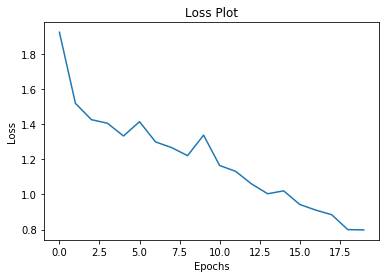

In [49]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Caption!

In [50]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [51]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> tom is wearing a brown turkey <end>
Prediction Caption: the turkey and hand throwing hand in a turkey and his wearing his hand is hand in milk is ground his hand is turkey is holding a turkey in a turkey and hand in his window and arm in another in an hand <end>


/Users/gloriayang/anaconda3/envs/syn/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


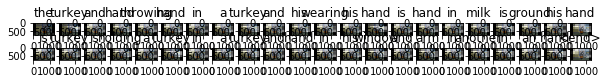

In [52]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

### Annotate images

In [18]:

todo = pd.read_csv('todo.csv')

In [19]:
todo

,image
0,frame12142.jpg
1,frame12143.jpg
2,frame12148.jpg
3,frame12150.jpg
4,frame12155.jpg
...,...
55207,frame99995.jpg
55208,frame99996.jpg
55209,frame99997.jpg
55210,frame99998.jpg


In [23]:
todolist = todo['image'].values.tolist()
results_list = []

In [22]:
for image in todolist:
    image_path = "./image/"+image
    result, attention_plot = evaluate(image_path)
    result.pop()
    sentence = ' '.join(result)
    results_list.append({image,result})

./image/frame12142.jpg
./image/frame12143.jpg
./image/frame12148.jpg
./image/frame12150.jpg
./image/frame12155.jpg
./image/frame12159.jpg
./image/frame12165.jpg
./image/frame12169.jpg
./image/frame1217.jpg
./image/frame12170.jpg
./image/frame12172.jpg
./image/frame12173.jpg
./image/frame12177.jpg
./image/frame12179.jpg
./image/frame12184.jpg
./image/frame12185.jpg
./image/frame12186.jpg
./image/frame12188.jpg
./image/frame12189.jpg
./image/frame12190.jpg
./image/frame12191.jpg
./image/frame12192.jpg
./image/frame12193.jpg
./image/frame12233.jpg
./image/frame12234.jpg
./image/frame12247.jpg
./image/frame12253.jpg
./image/frame12256.jpg
./image/frame12257.jpg
./image/frame12258.jpg
./image/frame12259.jpg
./image/frame12261.jpg
./image/frame12262.jpg
./image/frame12264.jpg
./image/frame12267.jpg
./image/frame12268.jpg
./image/frame12271.jpg
./image/frame12277.jpg
./image/frame12278.jpg
./image/frame12280.jpg
./image/frame12281.jpg
./image/frame12283.jpg
./image/frame12284.jpg
./image/fram

./image/frame15110.jpg
./image/frame15115.jpg
./image/frame15116.jpg
./image/frame15117.jpg
./image/frame15118.jpg
./image/frame15119.jpg
./image/frame15120.jpg
./image/frame15121.jpg
./image/frame15122.jpg
./image/frame15123.jpg
./image/frame15124.jpg
./image/frame15125.jpg
./image/frame15126.jpg
./image/frame15127.jpg
./image/frame15128.jpg
./image/frame15129.jpg
./image/frame15130.jpg
./image/frame15131.jpg
./image/frame15132.jpg
./image/frame15133.jpg
./image/frame15134.jpg
./image/frame15138.jpg
./image/frame15140.jpg
./image/frame15141.jpg
./image/frame15142.jpg
./image/frame15143.jpg
./image/frame15144.jpg
./image/frame15145.jpg
./image/frame15146.jpg
./image/frame15147.jpg
./image/frame15148.jpg
./image/frame15149.jpg
./image/frame15161.jpg
./image/frame15162.jpg
./image/frame15163.jpg
./image/frame15164.jpg
./image/frame15167.jpg
./image/frame15168.jpg
./image/frame15171.jpg
./image/frame15172.jpg
./image/frame15173.jpg
./image/frame15177.jpg
./image/frame15178.jpg
./image/fra

./image/frame16970.jpg
./image/frame16971.jpg
./image/frame16974.jpg
./image/frame16975.jpg
./image/frame1698.jpg
./image/frame16980.jpg
./image/frame16981.jpg
./image/frame16982.jpg
./image/frame16985.jpg
./image/frame16989.jpg
./image/frame1699.jpg
./image/frame16990.jpg
./image/frame16991.jpg
./image/frame16992.jpg
./image/frame16993.jpg
./image/frame16994.jpg
./image/frame16995.jpg
./image/frame16996.jpg
./image/frame16997.jpg
./image/frame16998.jpg
./image/frame16999.jpg
./image/frame17.jpg
./image/frame1700.jpg
./image/frame17000.jpg
./image/frame17001.jpg
./image/frame17002.jpg
./image/frame17004.jpg
./image/frame17005.jpg
./image/frame17006.jpg
./image/frame17007.jpg
./image/frame17008.jpg
./image/frame17009.jpg
./image/frame1701.jpg
./image/frame17010.jpg
./image/frame17011.jpg
./image/frame17012.jpg
./image/frame17013.jpg
./image/frame17014.jpg
./image/frame17016.jpg
./image/frame17018.jpg
./image/frame17019.jpg
./image/frame1702.jpg
./image/frame17020.jpg
./image/frame17021.

./image/frame19118.jpg
./image/frame19119.jpg
./image/frame19120.jpg
./image/frame19121.jpg
./image/frame19122.jpg
./image/frame19123.jpg
./image/frame19124.jpg
./image/frame19125.jpg
./image/frame19126.jpg
./image/frame19127.jpg
./image/frame19128.jpg
./image/frame19129.jpg
./image/frame19130.jpg
./image/frame19131.jpg
./image/frame19132.jpg
./image/frame19133.jpg
./image/frame19144.jpg
./image/frame19145.jpg
./image/frame19146.jpg
./image/frame19149.jpg
./image/frame19150.jpg
./image/frame19151.jpg
./image/frame19153.jpg
./image/frame19155.jpg
./image/frame19156.jpg
./image/frame19157.jpg
./image/frame19158.jpg
./image/frame19159.jpg
./image/frame1916.jpg
./image/frame19163.jpg
./image/frame19178.jpg
./image/frame19185.jpg
./image/frame19186.jpg
./image/frame19187.jpg
./image/frame192.jpg
./image/frame19203.jpg
./image/frame19210.jpg
./image/frame19213.jpg
./image/frame19214.jpg
./image/frame19215.jpg
./image/frame19216.jpg
./image/frame19217.jpg
./image/frame19219.jpg
./image/frame1

./image/frame21722.jpg
./image/frame21723.jpg
./image/frame21725.jpg
./image/frame21726.jpg
./image/frame21727.jpg
./image/frame21728.jpg
./image/frame21729.jpg
./image/frame21730.jpg
./image/frame21731.jpg
./image/frame21732.jpg
./image/frame21733.jpg
./image/frame21734.jpg
./image/frame21735.jpg
./image/frame21739.jpg
./image/frame21740.jpg
./image/frame21741.jpg
./image/frame21760.jpg
./image/frame21762.jpg
./image/frame21763.jpg
./image/frame21765.jpg
./image/frame21770.jpg
./image/frame21771.jpg
./image/frame21772.jpg
./image/frame21773.jpg
./image/frame21774.jpg
./image/frame21775.jpg
./image/frame21776.jpg
./image/frame21777.jpg
./image/frame21780.jpg
./image/frame21781.jpg
./image/frame21782.jpg
./image/frame21783.jpg
./image/frame21784.jpg
./image/frame21785.jpg
./image/frame21786.jpg
./image/frame21787.jpg
./image/frame21790.jpg
./image/frame21793.jpg
./image/frame21795.jpg
./image/frame21796.jpg
./image/frame21797.jpg
./image/frame21798.jpg
./image/frame21800.jpg
./image/fra

./image/frame23679.jpg
./image/frame23680.jpg
./image/frame23682.jpg
./image/frame23683.jpg
./image/frame23684.jpg
./image/frame23685.jpg
./image/frame23686.jpg
./image/frame23687.jpg
./image/frame23688.jpg
./image/frame23689.jpg
./image/frame23694.jpg
./image/frame23695.jpg
./image/frame23696.jpg
./image/frame23697.jpg
./image/frame23698.jpg
./image/frame23699.jpg
./image/frame237.jpg
./image/frame2370.jpg
./image/frame23700.jpg
./image/frame23701.jpg
./image/frame23702.jpg
./image/frame23705.jpg
./image/frame23706.jpg
./image/frame23709.jpg
./image/frame23710.jpg
./image/frame23711.jpg
./image/frame23717.jpg
./image/frame23723.jpg
./image/frame23724.jpg
./image/frame23725.jpg
./image/frame23726.jpg
./image/frame23727.jpg
./image/frame23728.jpg
./image/frame23729.jpg
./image/frame23730.jpg
./image/frame23736.jpg
./image/frame23737.jpg
./image/frame23738.jpg
./image/frame23740.jpg
./image/frame23741.jpg
./image/frame23742.jpg
./image/frame23743.jpg
./image/frame23744.jpg
./image/frame2

./image/frame26050.jpg
./image/frame26051.jpg
./image/frame26052.jpg
./image/frame26053.jpg
./image/frame26054.jpg
./image/frame26055.jpg
./image/frame26057.jpg
./image/frame26059.jpg
./image/frame2606.jpg
./image/frame26064.jpg
./image/frame26067.jpg
./image/frame26068.jpg
./image/frame26069.jpg
./image/frame2607.jpg
./image/frame26070.jpg
./image/frame2608.jpg
./image/frame26087.jpg
./image/frame26088.jpg
./image/frame26089.jpg
./image/frame26090.jpg
./image/frame26091.jpg
./image/frame26092.jpg
./image/frame26094.jpg
./image/frame26096.jpg
./image/frame26097.jpg
./image/frame26098.jpg
./image/frame26099.jpg
./image/frame261.jpg
./image/frame2610.jpg
./image/frame26101.jpg
./image/frame26102.jpg
./image/frame26103.jpg
./image/frame26104.jpg
./image/frame26106.jpg
./image/frame26107.jpg
./image/frame26109.jpg
./image/frame2611.jpg
./image/frame26110.jpg
./image/frame26111.jpg
./image/frame26112.jpg
./image/frame26113.jpg
./image/frame26114.jpg
./image/frame26115.jpg
./image/frame26116

./image/frame28613.jpg
./image/frame28614.jpg
./image/frame28615.jpg
./image/frame28620.jpg
./image/frame28621.jpg
./image/frame28622.jpg
./image/frame28623.jpg
./image/frame28624.jpg
./image/frame28625.jpg
./image/frame28626.jpg
./image/frame28627.jpg
./image/frame28628.jpg
./image/frame28629.jpg
./image/frame2863.jpg
./image/frame28630.jpg
./image/frame28631.jpg
./image/frame28632.jpg
./image/frame28633.jpg
./image/frame28634.jpg
./image/frame28635.jpg
./image/frame28636.jpg
./image/frame28637.jpg
./image/frame28638.jpg
./image/frame28639.jpg
./image/frame2864.jpg
./image/frame28640.jpg
./image/frame28641.jpg
./image/frame28642.jpg
./image/frame28643.jpg
./image/frame28644.jpg
./image/frame28645.jpg
./image/frame28646.jpg
./image/frame28649.jpg
./image/frame28650.jpg
./image/frame28651.jpg
./image/frame28652.jpg
./image/frame28653.jpg
./image/frame28654.jpg
./image/frame28656.jpg
./image/frame28657.jpg
./image/frame28661.jpg
./image/frame28662.jpg
./image/frame28663.jpg
./image/frame

./image/frame30846.jpg
./image/frame30847.jpg
./image/frame30848.jpg
./image/frame30849.jpg
./image/frame30850.jpg
./image/frame30851.jpg
./image/frame30852.jpg
./image/frame30853.jpg
./image/frame30855.jpg
./image/frame30856.jpg
./image/frame30857.jpg
./image/frame30863.jpg
./image/frame30864.jpg
./image/frame30865.jpg
./image/frame30866.jpg
./image/frame30867.jpg
./image/frame30868.jpg
./image/frame30869.jpg
./image/frame30870.jpg
./image/frame30871.jpg
./image/frame30877.jpg
./image/frame30878.jpg
./image/frame30880.jpg
./image/frame30881.jpg
./image/frame30883.jpg
./image/frame30884.jpg
./image/frame30886.jpg
./image/frame30893.jpg
./image/frame309.jpg
./image/frame30900.jpg
./image/frame30901.jpg
./image/frame30902.jpg
./image/frame30903.jpg
./image/frame30904.jpg
./image/frame30905.jpg
./image/frame30906.jpg
./image/frame30909.jpg
./image/frame30913.jpg
./image/frame30914.jpg
./image/frame30917.jpg
./image/frame30918.jpg
./image/frame30919.jpg
./image/frame30920.jpg
./image/frame

./image/frame33444.jpg
./image/frame33445.jpg
./image/frame33446.jpg
./image/frame33447.jpg
./image/frame33448.jpg
./image/frame33449.jpg
./image/frame3345.jpg
./image/frame33450.jpg
./image/frame33451.jpg
./image/frame33454.jpg
./image/frame33455.jpg
./image/frame33456.jpg
./image/frame33457.jpg
./image/frame33458.jpg
./image/frame33459.jpg
./image/frame33460.jpg
./image/frame33461.jpg
./image/frame33462.jpg
./image/frame33463.jpg
./image/frame33465.jpg
./image/frame33466.jpg
./image/frame33467.jpg
./image/frame33468.jpg
./image/frame33469.jpg
./image/frame33470.jpg
./image/frame33471.jpg
./image/frame33472.jpg
./image/frame33473.jpg
./image/frame33474.jpg
./image/frame33475.jpg
./image/frame33477.jpg
./image/frame33478.jpg
./image/frame33479.jpg
./image/frame33480.jpg
./image/frame33481.jpg
./image/frame33482.jpg
./image/frame33483.jpg
./image/frame33484.jpg
./image/frame33485.jpg
./image/frame33486.jpg
./image/frame33488.jpg
./image/frame33489.jpg
./image/frame3349.jpg
./image/frame

./image/frame35724.jpg
./image/frame35725.jpg
./image/frame35726.jpg
./image/frame35727.jpg
./image/frame35728.jpg
./image/frame35729.jpg
./image/frame35730.jpg
./image/frame35731.jpg
./image/frame35732.jpg
./image/frame35733.jpg
./image/frame35734.jpg
./image/frame35736.jpg
./image/frame35737.jpg
./image/frame35738.jpg
./image/frame35750.jpg
./image/frame35751.jpg
./image/frame35755.jpg
./image/frame35756.jpg
./image/frame35757.jpg
./image/frame35758.jpg
./image/frame3576.jpg
./image/frame35777.jpg
./image/frame35781.jpg
./image/frame35785.jpg
./image/frame35786.jpg
./image/frame35787.jpg
./image/frame35788.jpg
./image/frame35789.jpg
./image/frame35790.jpg
./image/frame35791.jpg
./image/frame35792.jpg
./image/frame35793.jpg
./image/frame35801.jpg
./image/frame35802.jpg
./image/frame35805.jpg
./image/frame35806.jpg
./image/frame35807.jpg
./image/frame35808.jpg
./image/frame35809.jpg
./image/frame35810.jpg
./image/frame35811.jpg
./image/frame35812.jpg
./image/frame35813.jpg
./image/fram

./image/frame3874.jpg
./image/frame38740.jpg
./image/frame38741.jpg
./image/frame38748.jpg
./image/frame38749.jpg
./image/frame3875.jpg
./image/frame38750.jpg
./image/frame38751.jpg
./image/frame3876.jpg
./image/frame38762.jpg
./image/frame38766.jpg
./image/frame38767.jpg
./image/frame38768.jpg
./image/frame38769.jpg
./image/frame38770.jpg
./image/frame38782.jpg
./image/frame38783.jpg
./image/frame38784.jpg
./image/frame38785.jpg
./image/frame38789.jpg
./image/frame38793.jpg
./image/frame38806.jpg
./image/frame3881.jpg
./image/frame38810.jpg
./image/frame3882.jpg
./image/frame38826.jpg
./image/frame38828.jpg
./image/frame3883.jpg
./image/frame3884.jpg
./image/frame38843.jpg
./image/frame38845.jpg
./image/frame38849.jpg
./image/frame3885.jpg
./image/frame38856.jpg
./image/frame38857.jpg
./image/frame38858.jpg
./image/frame38859.jpg
./image/frame3886.jpg
./image/frame38860.jpg
./image/frame38861.jpg
./image/frame38862.jpg
./image/frame38866.jpg
./image/frame38869.jpg
./image/frame3887.jp

./image/frame41163.jpg
./image/frame41164.jpg
./image/frame41166.jpg
./image/frame41167.jpg
./image/frame41169.jpg
./image/frame4117.jpg
./image/frame41171.jpg
./image/frame41179.jpg
./image/frame41180.jpg
./image/frame41181.jpg
./image/frame41182.jpg
./image/frame41183.jpg
./image/frame41184.jpg
./image/frame41185.jpg
./image/frame41186.jpg
./image/frame41187.jpg
./image/frame41188.jpg
./image/frame41189.jpg
./image/frame41190.jpg
./image/frame41191.jpg
./image/frame41192.jpg
./image/frame41193.jpg
./image/frame41194.jpg
./image/frame41195.jpg
./image/frame41196.jpg
./image/frame41197.jpg
./image/frame41198.jpg
./image/frame41199.jpg
./image/frame41200.jpg
./image/frame41202.jpg
./image/frame41203.jpg
./image/frame41205.jpg
./image/frame41206.jpg
./image/frame41207.jpg
./image/frame41209.jpg
./image/frame4121.jpg
./image/frame41210.jpg
./image/frame41211.jpg
./image/frame41212.jpg
./image/frame41213.jpg
./image/frame41214.jpg
./image/frame41215.jpg
./image/frame41216.jpg
./image/frame

./image/frame44428.jpg
./image/frame44429.jpg
./image/frame4443.jpg
./image/frame44433.jpg
./image/frame44434.jpg
./image/frame44435.jpg
./image/frame44436.jpg
./image/frame44437.jpg
./image/frame44438.jpg
./image/frame44439.jpg
./image/frame4444.jpg
./image/frame44440.jpg
./image/frame44441.jpg
./image/frame44442.jpg
./image/frame44443.jpg
./image/frame44444.jpg
./image/frame44445.jpg
./image/frame44446.jpg
./image/frame44447.jpg
./image/frame44448.jpg
./image/frame44449.jpg
./image/frame4445.jpg
./image/frame44450.jpg
./image/frame44451.jpg
./image/frame44452.jpg
./image/frame44453.jpg
./image/frame44454.jpg
./image/frame44455.jpg
./image/frame44456.jpg
./image/frame44457.jpg
./image/frame44458.jpg
./image/frame44459.jpg
./image/frame4446.jpg
./image/frame44460.jpg
./image/frame44461.jpg
./image/frame44462.jpg
./image/frame44463.jpg
./image/frame44464.jpg
./image/frame44465.jpg
./image/frame44466.jpg
./image/frame44467.jpg
./image/frame44468.jpg
./image/frame44469.jpg
./image/frame44

./image/frame47606.jpg
./image/frame47607.jpg
./image/frame47608.jpg
./image/frame47609.jpg
./image/frame4761.jpg
./image/frame47610.jpg
./image/frame47611.jpg
./image/frame47612.jpg
./image/frame47613.jpg
./image/frame47620.jpg
./image/frame47621.jpg
./image/frame47622.jpg
./image/frame47623.jpg
./image/frame47624.jpg
./image/frame47625.jpg
./image/frame47626.jpg
./image/frame47627.jpg
./image/frame47628.jpg
./image/frame47629.jpg
./image/frame4763.jpg
./image/frame47630.jpg
./image/frame47632.jpg
./image/frame47633.jpg
./image/frame47634.jpg
./image/frame47635.jpg
./image/frame47636.jpg
./image/frame47637.jpg
./image/frame47638.jpg
./image/frame47639.jpg
./image/frame47640.jpg
./image/frame47641.jpg
./image/frame47643.jpg
./image/frame47644.jpg
./image/frame47645.jpg
./image/frame47646.jpg
./image/frame47647.jpg
./image/frame47648.jpg
./image/frame47649.jpg
./image/frame47650.jpg
./image/frame47656.jpg
./image/frame47657.jpg
./image/frame47658.jpg
./image/frame47659.jpg
./image/frame

./image/frame50193.jpg
./image/frame50195.jpg
./image/frame5020.jpg
./image/frame50201.jpg
./image/frame50202.jpg
./image/frame50203.jpg
./image/frame50204.jpg
./image/frame50205.jpg
./image/frame50207.jpg
./image/frame50208.jpg
./image/frame50209.jpg
./image/frame5021.jpg
./image/frame50210.jpg
./image/frame50211.jpg
./image/frame50212.jpg
./image/frame50213.jpg
./image/frame50214.jpg
./image/frame50215.jpg
./image/frame50218.jpg
./image/frame5022.jpg
./image/frame50220.jpg
./image/frame50222.jpg
./image/frame50223.jpg
./image/frame50225.jpg
./image/frame50226.jpg
./image/frame50227.jpg
./image/frame50228.jpg
./image/frame50229.jpg
./image/frame5023.jpg
./image/frame50230.jpg
./image/frame50231.jpg
./image/frame50232.jpg
./image/frame50233.jpg
./image/frame50235.jpg
./image/frame50239.jpg
./image/frame5024.jpg
./image/frame50242.jpg
./image/frame50243.jpg
./image/frame50244.jpg
./image/frame50245.jpg
./image/frame50247.jpg
./image/frame50248.jpg
./image/frame50249.jpg
./image/frame502

./image/frame53031.jpg
./image/frame53032.jpg
./image/frame53033.jpg
./image/frame53035.jpg
./image/frame53036.jpg
./image/frame53040.jpg
./image/frame53043.jpg
./image/frame53045.jpg
./image/frame53046.jpg
./image/frame53047.jpg
./image/frame53060.jpg
./image/frame53061.jpg
./image/frame53064.jpg
./image/frame53067.jpg
./image/frame53068.jpg
./image/frame53069.jpg
./image/frame53070.jpg
./image/frame53071.jpg
./image/frame53072.jpg
./image/frame53073.jpg
./image/frame53074.jpg
./image/frame53075.jpg
./image/frame53076.jpg
./image/frame53081.jpg
./image/frame53084.jpg
./image/frame53086.jpg
./image/frame53092.jpg
./image/frame53093.jpg
./image/frame53094.jpg
./image/frame53095.jpg
./image/frame53096.jpg
./image/frame53097.jpg
./image/frame53098.jpg
./image/frame53099.jpg
./image/frame53100.jpg
./image/frame53101.jpg
./image/frame53103.jpg
./image/frame53104.jpg
./image/frame53105.jpg
./image/frame53106.jpg
./image/frame5311.jpg
./image/frame53110.jpg
./image/frame53111.jpg
./image/fram

./image/frame55512.jpg
./image/frame55515.jpg
./image/frame55516.jpg
./image/frame55517.jpg
./image/frame55518.jpg
./image/frame55519.jpg
./image/frame55537.jpg
./image/frame55540.jpg
./image/frame55541.jpg
./image/frame55543.jpg
./image/frame55544.jpg
./image/frame55545.jpg
./image/frame55546.jpg
./image/frame55547.jpg
./image/frame55548.jpg
./image/frame55549.jpg
./image/frame55550.jpg
./image/frame55552.jpg
./image/frame55553.jpg
./image/frame55573.jpg
./image/frame55574.jpg
./image/frame55576.jpg
./image/frame55577.jpg
./image/frame55583.jpg
./image/frame55584.jpg
./image/frame55585.jpg
./image/frame55586.jpg
./image/frame55587.jpg
./image/frame55588.jpg
./image/frame55593.jpg
./image/frame55594.jpg
./image/frame55595.jpg
./image/frame55596.jpg
./image/frame55597.jpg
./image/frame55598.jpg
./image/frame55604.jpg
./image/frame55605.jpg
./image/frame55606.jpg
./image/frame55607.jpg
./image/frame55608.jpg
./image/frame55609.jpg
./image/frame55610.jpg
./image/frame55619.jpg
./image/fra

./image/frame58610.jpg
./image/frame58611.jpg
./image/frame58612.jpg
./image/frame58613.jpg
./image/frame58614.jpg
./image/frame58615.jpg
./image/frame58617.jpg
./image/frame58618.jpg
./image/frame58619.jpg
./image/frame58620.jpg
./image/frame58621.jpg
./image/frame58622.jpg
./image/frame58624.jpg
./image/frame58625.jpg
./image/frame58626.jpg
./image/frame58627.jpg
./image/frame58629.jpg
./image/frame5863.jpg
./image/frame58631.jpg
./image/frame58632.jpg
./image/frame58633.jpg
./image/frame58634.jpg
./image/frame58635.jpg
./image/frame58636.jpg
./image/frame58642.jpg
./image/frame58644.jpg
./image/frame58645.jpg
./image/frame58646.jpg
./image/frame58647.jpg
./image/frame58648.jpg
./image/frame58649.jpg
./image/frame58650.jpg
./image/frame58651.jpg
./image/frame58652.jpg
./image/frame58653.jpg
./image/frame58654.jpg
./image/frame58655.jpg
./image/frame58656.jpg
./image/frame58658.jpg
./image/frame58659.jpg
./image/frame5866.jpg
./image/frame58660.jpg
./image/frame58661.jpg
./image/frame

./image/frame61555.jpg
./image/frame61556.jpg
./image/frame61557.jpg
./image/frame6156.jpg
./image/frame61560.jpg
./image/frame61562.jpg
./image/frame61563.jpg
./image/frame61565.jpg
./image/frame61566.jpg
./image/frame61567.jpg
./image/frame61568.jpg
./image/frame61569.jpg
./image/frame6157.jpg
./image/frame61570.jpg
./image/frame61571.jpg
./image/frame61573.jpg
./image/frame61574.jpg
./image/frame6158.jpg
./image/frame61583.jpg
./image/frame61584.jpg
./image/frame61585.jpg
./image/frame61586.jpg
./image/frame61587.jpg
./image/frame6159.jpg
./image/frame61592.jpg
./image/frame61593.jpg
./image/frame61595.jpg
./image/frame61596.jpg
./image/frame61597.jpg
./image/frame61600.jpg
./image/frame61601.jpg
./image/frame61602.jpg
./image/frame61603.jpg
./image/frame61604.jpg
./image/frame61605.jpg
./image/frame6161.jpg
./image/frame61619.jpg
./image/frame61624.jpg
./image/frame6163.jpg
./image/frame6164.jpg
./image/frame61643.jpg
./image/frame61644.jpg
./image/frame61649.jpg
./image/frame61650

./image/frame64443.jpg
./image/frame64445.jpg
./image/frame64446.jpg
./image/frame64447.jpg
./image/frame64448.jpg
./image/frame64449.jpg
./image/frame6445.jpg
./image/frame64451.jpg
./image/frame64452.jpg
./image/frame64455.jpg
./image/frame64456.jpg
./image/frame64457.jpg
./image/frame64460.jpg
./image/frame64461.jpg
./image/frame64470.jpg
./image/frame64472.jpg
./image/frame64478.jpg
./image/frame64482.jpg
./image/frame64483.jpg
./image/frame64484.jpg
./image/frame64485.jpg
./image/frame64486.jpg
./image/frame64487.jpg
./image/frame64488.jpg
./image/frame64489.jpg
./image/frame64490.jpg
./image/frame64491.jpg
./image/frame64492.jpg
./image/frame64493.jpg
./image/frame64494.jpg
./image/frame64495.jpg
./image/frame64496.jpg
./image/frame64497.jpg
./image/frame6452.jpg
./image/frame64525.jpg
./image/frame64526.jpg
./image/frame64527.jpg
./image/frame64528.jpg
./image/frame64529.jpg
./image/frame6453.jpg
./image/frame64530.jpg
./image/frame64531.jpg
./image/frame64532.jpg
./image/frame6

./image/frame66533.jpg
./image/frame66534.jpg
./image/frame66535.jpg
./image/frame6654.jpg
./image/frame66541.jpg
./image/frame66543.jpg
./image/frame66544.jpg
./image/frame66545.jpg
./image/frame66546.jpg
./image/frame66547.jpg
./image/frame66548.jpg
./image/frame66549.jpg
./image/frame6655.jpg
./image/frame66550.jpg
./image/frame66551.jpg
./image/frame66552.jpg
./image/frame66553.jpg
./image/frame66554.jpg
./image/frame66555.jpg
./image/frame66556.jpg
./image/frame66557.jpg
./image/frame66558.jpg
./image/frame66559.jpg
./image/frame6656.jpg
./image/frame66560.jpg
./image/frame66561.jpg
./image/frame6657.jpg
./image/frame66574.jpg
./image/frame66575.jpg
./image/frame66576.jpg
./image/frame66577.jpg
./image/frame66578.jpg
./image/frame66579.jpg
./image/frame6658.jpg
./image/frame66580.jpg
./image/frame66581.jpg
./image/frame66582.jpg
./image/frame66583.jpg
./image/frame66584.jpg
./image/frame66585.jpg
./image/frame6659.jpg
./image/frame6660.jpg
./image/frame6661.jpg
./image/frame66614.

./image/frame69422.jpg
./image/frame69423.jpg
./image/frame69425.jpg
./image/frame69426.jpg
./image/frame69427.jpg
./image/frame69428.jpg
./image/frame69429.jpg
./image/frame69432.jpg
./image/frame69433.jpg
./image/frame69434.jpg
./image/frame69438.jpg
./image/frame69439.jpg
./image/frame6944.jpg
./image/frame69441.jpg
./image/frame69443.jpg
./image/frame69445.jpg
./image/frame69446.jpg
./image/frame69447.jpg
./image/frame6945.jpg
./image/frame69454.jpg
./image/frame69457.jpg
./image/frame69458.jpg
./image/frame69459.jpg
./image/frame69462.jpg
./image/frame69463.jpg
./image/frame69464.jpg
./image/frame69466.jpg
./image/frame69467.jpg
./image/frame69468.jpg
./image/frame69469.jpg
./image/frame6947.jpg
./image/frame69470.jpg
./image/frame69473.jpg
./image/frame69474.jpg
./image/frame69475.jpg
./image/frame69476.jpg
./image/frame69477.jpg
./image/frame69478.jpg
./image/frame69479.jpg
./image/frame6948.jpg
./image/frame69480.jpg
./image/frame69481.jpg
./image/frame69483.jpg
./image/frame69

./image/frame72078.jpg
./image/frame72079.jpg
./image/frame72080.jpg
./image/frame72081.jpg
./image/frame72082.jpg
./image/frame72083.jpg
./image/frame72084.jpg
./image/frame72085.jpg
./image/frame72087.jpg
./image/frame72088.jpg
./image/frame72089.jpg
./image/frame7209.jpg
./image/frame72090.jpg
./image/frame72091.jpg
./image/frame72093.jpg
./image/frame72095.jpg
./image/frame72096.jpg
./image/frame72097.jpg
./image/frame72098.jpg
./image/frame7210.jpg
./image/frame72100.jpg
./image/frame72101.jpg
./image/frame72102.jpg
./image/frame72103.jpg
./image/frame72104.jpg
./image/frame72105.jpg
./image/frame72110.jpg
./image/frame72111.jpg
./image/frame72112.jpg
./image/frame72113.jpg
./image/frame72115.jpg
./image/frame72116.jpg
./image/frame72117.jpg
./image/frame72118.jpg
./image/frame72119.jpg
./image/frame72120.jpg
./image/frame72124.jpg
./image/frame72125.jpg
./image/frame72131.jpg
./image/frame72132.jpg
./image/frame72133.jpg
./image/frame72134.jpg
./image/frame72135.jpg
./image/frame

./image/frame74404.jpg
./image/frame74405.jpg
./image/frame74406.jpg
./image/frame74407.jpg
./image/frame74408.jpg
./image/frame74409.jpg
./image/frame7441.jpg
./image/frame74415.jpg
./image/frame74420.jpg
./image/frame74421.jpg
./image/frame74422.jpg
./image/frame74424.jpg
./image/frame74427.jpg
./image/frame7443.jpg
./image/frame74430.jpg
./image/frame74432.jpg
./image/frame74433.jpg
./image/frame74439.jpg
./image/frame7444.jpg
./image/frame74440.jpg
./image/frame74441.jpg
./image/frame74448.jpg
./image/frame74449.jpg
./image/frame7445.jpg
./image/frame74450.jpg
./image/frame74452.jpg
./image/frame74453.jpg
./image/frame74454.jpg
./image/frame74455.jpg
./image/frame74456.jpg
./image/frame7446.jpg
./image/frame74461.jpg
./image/frame74462.jpg
./image/frame74463.jpg
./image/frame74464.jpg
./image/frame74465.jpg
./image/frame74466.jpg
./image/frame74467.jpg
./image/frame74468.jpg
./image/frame74469.jpg
./image/frame7447.jpg
./image/frame74476.jpg
./image/frame74477.jpg
./image/frame7447

./image/frame76692.jpg
./image/frame76693.jpg
./image/frame76694.jpg
./image/frame76695.jpg
./image/frame76697.jpg
./image/frame76698.jpg
./image/frame76699.jpg
./image/frame76700.jpg
./image/frame76706.jpg
./image/frame76707.jpg
./image/frame76708.jpg
./image/frame7671.jpg
./image/frame76717.jpg
./image/frame76718.jpg
./image/frame76719.jpg
./image/frame7672.jpg
./image/frame76720.jpg
./image/frame76721.jpg
./image/frame76722.jpg
./image/frame76723.jpg
./image/frame76724.jpg
./image/frame76725.jpg
./image/frame76726.jpg
./image/frame76727.jpg
./image/frame76728.jpg
./image/frame76729.jpg
./image/frame7673.jpg
./image/frame76730.jpg
./image/frame76731.jpg
./image/frame76732.jpg
./image/frame76733.jpg
./image/frame76734.jpg
./image/frame76736.jpg
./image/frame76737.jpg
./image/frame76738.jpg
./image/frame76739.jpg
./image/frame76740.jpg
./image/frame76741.jpg
./image/frame76742.jpg
./image/frame76743.jpg
./image/frame76744.jpg
./image/frame76745.jpg
./image/frame76746.jpg
./image/frame7

./image/frame79136.jpg
./image/frame79137.jpg
./image/frame79138.jpg
./image/frame79139.jpg
./image/frame79140.jpg
./image/frame79141.jpg
./image/frame79142.jpg
./image/frame79143.jpg
./image/frame79144.jpg
./image/frame79145.jpg
./image/frame79146.jpg
./image/frame79147.jpg
./image/frame79148.jpg
./image/frame79149.jpg
./image/frame79150.jpg
./image/frame79151.jpg
./image/frame79152.jpg
./image/frame79153.jpg
./image/frame79154.jpg
./image/frame79155.jpg
./image/frame79156.jpg
./image/frame79157.jpg
./image/frame79158.jpg
./image/frame79160.jpg
./image/frame79162.jpg
./image/frame79163.jpg
./image/frame79165.jpg
./image/frame79169.jpg
./image/frame79173.jpg
./image/frame79176.jpg
./image/frame79177.jpg
./image/frame79178.jpg
./image/frame79179.jpg
./image/frame79180.jpg
./image/frame79181.jpg
./image/frame79182.jpg
./image/frame79183.jpg
./image/frame79184.jpg
./image/frame79185.jpg
./image/frame79186.jpg
./image/frame79187.jpg
./image/frame79188.jpg
./image/frame79189.jpg
./image/fra

./image/frame82030.jpg
./image/frame82036.jpg
./image/frame82037.jpg
./image/frame82038.jpg
./image/frame82039.jpg
./image/frame8204.jpg
./image/frame82041.jpg
./image/frame82042.jpg
./image/frame82043.jpg
./image/frame82044.jpg
./image/frame82045.jpg
./image/frame82049.jpg
./image/frame8205.jpg
./image/frame82050.jpg
./image/frame82052.jpg
./image/frame82053.jpg
./image/frame82059.jpg
./image/frame8206.jpg
./image/frame82060.jpg
./image/frame82062.jpg
./image/frame82063.jpg
./image/frame82064.jpg
./image/frame82065.jpg
./image/frame82066.jpg
./image/frame82067.jpg
./image/frame82068.jpg
./image/frame8207.jpg
./image/frame82071.jpg
./image/frame82072.jpg
./image/frame82074.jpg
./image/frame82075.jpg
./image/frame82076.jpg
./image/frame82079.jpg
./image/frame8208.jpg
./image/frame82080.jpg
./image/frame82088.jpg
./image/frame82089.jpg
./image/frame8209.jpg
./image/frame82090.jpg
./image/frame82092.jpg
./image/frame82093.jpg
./image/frame82094.jpg
./image/frame82095.jpg
./image/frame8209

./image/frame84535.jpg
./image/frame84536.jpg
./image/frame84537.jpg
./image/frame84539.jpg
./image/frame8454.jpg
./image/frame84540.jpg
./image/frame84541.jpg
./image/frame84542.jpg
./image/frame84543.jpg
./image/frame84544.jpg
./image/frame84545.jpg
./image/frame84546.jpg
./image/frame84548.jpg
./image/frame84549.jpg
./image/frame8455.jpg
./image/frame84550.jpg
./image/frame84551.jpg
./image/frame84554.jpg
./image/frame84555.jpg
./image/frame84558.jpg
./image/frame84559.jpg
./image/frame8456.jpg
./image/frame84562.jpg
./image/frame84567.jpg
./image/frame8457.jpg
./image/frame84573.jpg
./image/frame84574.jpg
./image/frame84575.jpg
./image/frame84576.jpg
./image/frame84581.jpg
./image/frame84582.jpg
./image/frame84583.jpg
./image/frame84585.jpg
./image/frame84586.jpg
./image/frame84587.jpg
./image/frame84588.jpg
./image/frame84589.jpg
./image/frame8459.jpg
./image/frame84590.jpg
./image/frame84595.jpg
./image/frame84596.jpg
./image/frame84597.jpg
./image/frame84598.jpg
./image/frame845

./image/frame87369.jpg
./image/frame8737.jpg
./image/frame87370.jpg
./image/frame87371.jpg
./image/frame87372.jpg
./image/frame87373.jpg
./image/frame87374.jpg
./image/frame87375.jpg
./image/frame87376.jpg
./image/frame87377.jpg
./image/frame87378.jpg
./image/frame8738.jpg
./image/frame87381.jpg
./image/frame87383.jpg
./image/frame87384.jpg
./image/frame87385.jpg
./image/frame87387.jpg
./image/frame8739.jpg
./image/frame87390.jpg
./image/frame87391.jpg
./image/frame87392.jpg
./image/frame87393.jpg
./image/frame87394.jpg
./image/frame87396.jpg
./image/frame87397.jpg
./image/frame87398.jpg
./image/frame87399.jpg
./image/frame874.jpg
./image/frame8740.jpg
./image/frame87400.jpg
./image/frame87401.jpg
./image/frame87402.jpg
./image/frame87403.jpg
./image/frame87404.jpg
./image/frame87405.jpg
./image/frame87406.jpg
./image/frame87407.jpg
./image/frame87408.jpg
./image/frame87409.jpg
./image/frame8741.jpg
./image/frame87410.jpg
./image/frame87411.jpg
./image/frame87412.jpg
./image/frame87413

./image/frame90109.jpg
./image/frame9011.jpg
./image/frame90110.jpg
./image/frame90111.jpg
./image/frame90112.jpg
./image/frame90113.jpg
./image/frame90114.jpg
./image/frame90115.jpg
./image/frame90116.jpg
./image/frame90117.jpg
./image/frame90118.jpg
./image/frame90119.jpg
./image/frame9012.jpg
./image/frame90120.jpg
./image/frame90121.jpg
./image/frame90122.jpg
./image/frame90123.jpg
./image/frame90124.jpg
./image/frame90125.jpg
./image/frame90126.jpg
./image/frame90127.jpg
./image/frame90128.jpg
./image/frame90129.jpg
./image/frame9013.jpg
./image/frame90130.jpg
./image/frame90131.jpg
./image/frame90132.jpg
./image/frame90134.jpg
./image/frame90135.jpg
./image/frame90136.jpg
./image/frame90137.jpg
./image/frame90138.jpg
./image/frame90139.jpg
./image/frame9014.jpg
./image/frame90140.jpg
./image/frame90141.jpg
./image/frame90142.jpg
./image/frame90144.jpg
./image/frame90148.jpg
./image/frame90149.jpg
./image/frame90150.jpg
./image/frame90151.jpg
./image/frame90152.jpg
./image/frame90

./image/frame92574.jpg
./image/frame92575.jpg
./image/frame92582.jpg
./image/frame92585.jpg
./image/frame92586.jpg
./image/frame92589.jpg
./image/frame92593.jpg
./image/frame92598.jpg
./image/frame92602.jpg
./image/frame92605.jpg
./image/frame92607.jpg
./image/frame92608.jpg
./image/frame92609.jpg
./image/frame92610.jpg
./image/frame92612.jpg
./image/frame92614.jpg
./image/frame92615.jpg
./image/frame92616.jpg
./image/frame92620.jpg
./image/frame92625.jpg
./image/frame92626.jpg
./image/frame92627.jpg
./image/frame92628.jpg
./image/frame92629.jpg
./image/frame92630.jpg
./image/frame92631.jpg
./image/frame92632.jpg
./image/frame92633.jpg
./image/frame92634.jpg
./image/frame92635.jpg
./image/frame92636.jpg
./image/frame92637.jpg
./image/frame92638.jpg
./image/frame92639.jpg
./image/frame92640.jpg
./image/frame92641.jpg
./image/frame92644.jpg
./image/frame92645.jpg
./image/frame9265.jpg
./image/frame92650.jpg
./image/frame92651.jpg
./image/frame92652.jpg
./image/frame92653.jpg
./image/fram

./image/frame95011.jpg
./image/frame95012.jpg
./image/frame95013.jpg
./image/frame95014.jpg
./image/frame95015.jpg
./image/frame95016.jpg
./image/frame95017.jpg
./image/frame95018.jpg
./image/frame95019.jpg
./image/frame9502.jpg
./image/frame95020.jpg
./image/frame95021.jpg
./image/frame95022.jpg
./image/frame95023.jpg
./image/frame95024.jpg
./image/frame95025.jpg
./image/frame95026.jpg
./image/frame95027.jpg
./image/frame95028.jpg
./image/frame95029.jpg
./image/frame9503.jpg
./image/frame95030.jpg
./image/frame95031.jpg
./image/frame95032.jpg
./image/frame95033.jpg
./image/frame95034.jpg
./image/frame95035.jpg
./image/frame95036.jpg
./image/frame95037.jpg
./image/frame95038.jpg
./image/frame95039.jpg
./image/frame9504.jpg
./image/frame95040.jpg
./image/frame95041.jpg
./image/frame95042.jpg
./image/frame95043.jpg
./image/frame95044.jpg
./image/frame95045.jpg
./image/frame95046.jpg
./image/frame95047.jpg
./image/frame95048.jpg
./image/frame95049.jpg
./image/frame9505.jpg
./image/frame95

./image/frame96918.jpg
./image/frame96919.jpg
./image/frame96920.jpg
./image/frame96921.jpg
./image/frame96922.jpg
./image/frame96923.jpg
./image/frame96924.jpg
./image/frame96925.jpg
./image/frame96926.jpg
./image/frame96927.jpg
./image/frame96928.jpg
./image/frame96929.jpg
./image/frame96930.jpg
./image/frame96931.jpg
./image/frame96932.jpg
./image/frame96933.jpg
./image/frame96934.jpg
./image/frame96935.jpg
./image/frame96938.jpg
./image/frame96939.jpg
./image/frame96941.jpg
./image/frame96942.jpg
./image/frame96943.jpg
./image/frame96944.jpg
./image/frame96945.jpg
./image/frame96946.jpg
./image/frame96949.jpg
./image/frame96950.jpg
./image/frame96951.jpg
./image/frame96952.jpg
./image/frame96953.jpg
./image/frame96955.jpg
./image/frame96956.jpg
./image/frame96957.jpg
./image/frame96958.jpg
./image/frame96962.jpg
./image/frame96963.jpg
./image/frame96964.jpg
./image/frame96965.jpg
./image/frame96966.jpg
./image/frame96967.jpg
./image/frame96969.jpg
./image/frame96970.jpg
./image/fra

./image/frame99169.jpg
./image/frame99170.jpg
./image/frame99171.jpg
./image/frame99172.jpg
./image/frame99173.jpg
./image/frame99175.jpg
./image/frame99176.jpg
./image/frame99177.jpg
./image/frame99178.jpg
./image/frame99179.jpg
./image/frame99181.jpg
./image/frame99182.jpg
./image/frame99183.jpg
./image/frame99186.jpg
./image/frame99187.jpg
./image/frame99188.jpg
./image/frame99191.jpg
./image/frame99192.jpg
./image/frame99197.jpg
./image/frame99198.jpg
./image/frame99199.jpg
./image/frame992.jpg
./image/frame99200.jpg
./image/frame99201.jpg
./image/frame99202.jpg
./image/frame99203.jpg
./image/frame99204.jpg
./image/frame99205.jpg
./image/frame99206.jpg
./image/frame99207.jpg
./image/frame99208.jpg
./image/frame99209.jpg
./image/frame99210.jpg
./image/frame99211.jpg
./image/frame99213.jpg
./image/frame99214.jpg
./image/frame99215.jpg
./image/frame99216.jpg
./image/frame99217.jpg
./image/frame99218.jpg
./image/frame99219.jpg
./image/frame99220.jpg
./image/frame99221.jpg
./image/frame

In [31]:
results = pd.DataFrame(result_list, columns = ['image','caption'])

,image,caption
0,1,2
1,3,4


['of', 'books', 'to', 'the', 'fork', 'in', 'catch', 'tom', 'is', 'eating', 'brushing', 'jerry', 'softly', '<end>']


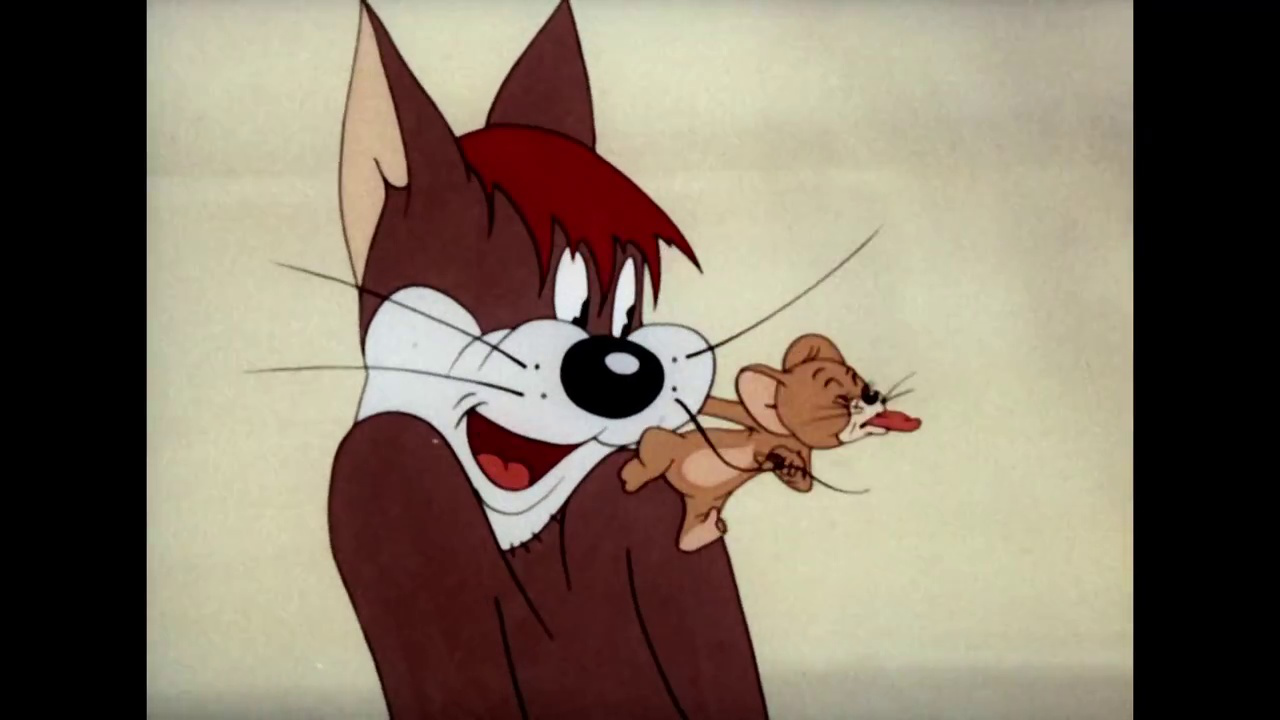

In [67]:
results.to_csv('results.csv',index = False, header=True)